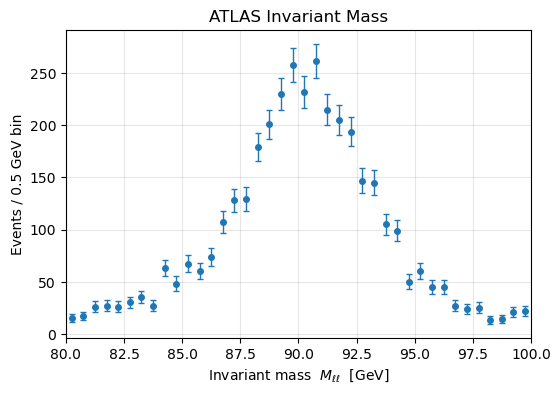

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

df = pd.read_csv('atlas_z_to_ll.csv', header=None)
df.columns = ['pT1', 'pT2', 'eta1', 'eta2', 'phi1', 'phi2', 'E1', 'E2']
df = df.apply(pd.to_numeric, errors='coerce')
df = df.dropna()

def compute_components(pT, eta, phi, E):
    px = pT * np.cos(phi)
    py = pT * np.sin(phi)
    pz = pT * np.sinh(eta)
    return px, py, pz, E

px1, py1, pz1, E1 = compute_components(df['pT1'], df['eta1'], df['phi1'], df['E1'])
px2, py2, pz2, E2 = compute_components(df['pT2'], df['eta2'], df['phi2'], df['E2'])

#Calculate invariant mass
E_total = E1 + E2
px_total = px1 + px2
py_total = py1 + py2
pz_total = pz1 + pz2
M = np.sqrt(E_total**2 - (px_total**2 + py_total**2 + pz_total**2))

#Histogram with error bars
bins = np.linspace(80, 100, 41)
counts, _ = np.histogram(M, bins=bins)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
errors = np.sqrt(counts)

#Plot
plt.figure(figsize=(6,4))
plt.errorbar(bin_centers, counts, yerr=errors,
             fmt='o', markersize=4, capsize=2, lw=1)
plt.xlabel(r'Invariant mass  $M_{\ell\ell}$  [GeV]')
plt.ylabel('Events / 0.5 GeV bin')
plt.title(r'ATLAS Invariant Mass')
plt.xlim(80, 100)
plt.grid(True, alpha=0.3)

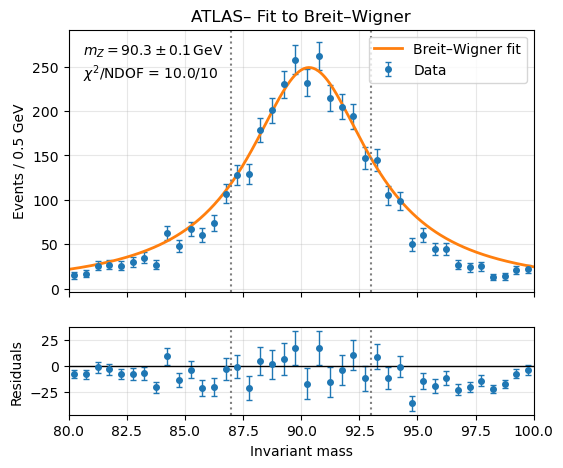

In [2]:
#Part 2

#Reuse histogram results from Part 1
N_HALF = len(M) // 2  # 2500 for 5000
def breit_wigner(m, m0, Gamma):
    """Breit–Wigner line-shape with fixed normalization N_HALF."""
    return N_HALF * (Gamma/2.0/np.pi) / ((m - m0)**2 + (Gamma/2.0)**2)

#Select fit window
mask        = (bin_centers > 87) & (bin_centers < 93)
x_fit       = bin_centers[mask]
y_fit       = counts[mask]
sigma_fit   = errors[mask]
p0       = [91.0, 3.0]
popt, pcov = curve_fit(breit_wigner, x_fit, y_fit,
                       p0=p0, sigma=sigma_fit,
                       absolute_sigma=True)
m0_fit,  Gamma_fit   = popt
m0_err, Gamma_err    = np.sqrt(np.diag(pcov))
chi2_val  = np.sum(((y_fit - breit_wigner(x_fit, *popt)) / sigma_fit)**2)
ndof      = len(x_fit) - len(popt)

#Plot
fig, (ax, ax_res) = plt.subplots(2, 1, sharex=True,
                                 gridspec_kw={'height_ratios': [3, 1]},
                                 figsize=(6,5))

#Main
ax.errorbar(bin_centers, counts, yerr=errors,
            fmt='o', markersize=4, capsize=2, lw=1, label='Data')

m_plot = np.linspace(80, 100, 400)
ax.plot(m_plot, breit_wigner(m_plot, *popt), '-', lw=2, label='Breit–Wigner fit')

ax.set_ylabel('Events / 0.5 GeV')
ax.set_title(r'ATLAS– Fit to Breit–Wigner')
ax.legend()
ax.grid(alpha=0.3)

#Annotation
text  = (rf"$m_Z = {m0_fit:.1f}\pm{m0_err:.1f}\,\mathrm{{GeV}}$" "\n"
         rf"$\chi^2$/NDOF = {chi2_val:.1f}/{ndof}")
ax.text(0.03, 0.95, text, va='top', ha='left', transform=ax.transAxes)

#Residuals panel
residuals = counts - breit_wigner(bin_centers, *popt)
ax_res.errorbar(bin_centers, residuals, yerr=errors,
                fmt='o', markersize=4, capsize=2, lw=1)
ax_res.axhline(0, lw=1, color='k')
ax_res.set_xlabel(r'Invariant mass')
ax_res.set_ylabel('Residuals')
ax_res.set_xlim(80, 100)
ax_res.grid(alpha=0.3)

#Vertical dotted lines to show fit range
for vline in (87, 93):
    ax.axvline(vline, ls=':', color='gray')
    ax_res.axvline(vline, ls=':', color='gray')

plt.savefig("Figure1.pdf", dpi=400)

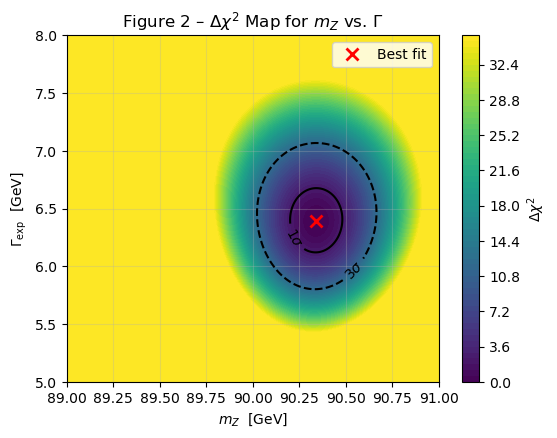

In [3]:
#Part 3

#Build 300×300 grid
m0_vals    = np.linspace(89.0, 91.0, 300)  
Gamma_vals = np.linspace(5.0, 8.0, 300)
m0_grid, Gamma_grid = np.meshgrid(m0_vals, Gamma_vals, indexing='xy')

#Compute χ2 at each grid point
predicted  = breit_wigner(x_fit[:, None, None],
                          m0_grid[None, :, :],
                          Gamma_grid[None, :, :])
chi2_grid  = np.sum(((y_fit[:, None, None] - predicted) / sigma_fit[:, None, None])**2,
                    axis=0)

#For visibility
delta_chi2 = chi2_grid - chi2_grid.min()
delta_clipped = np.clip(delta_chi2, 0, 35)

#Plot filled contours
fig, ax = plt.subplots(figsize=(6, 4.5))
cf = ax.contourf(m0_grid, Gamma_grid, delta_clipped,
                 levels=60, vmin=0, vmax=35)
cbar = plt.colorbar(cf, ax=ax, label=r'$\Delta\chi^{2}$')

#Levels for 2 parameters
levels = [2.30, 11.83]
ct = ax.contour(m0_grid, Gamma_grid, delta_chi2,
                levels=levels, colors='k', linestyles=['-', '--'])
ax.clabel(ct, fmt={2.30: r'1$\sigma$', 11.83: r'3$\sigma$'})

# Best fit marker
ax.plot(m0_fit, Gamma_fit, 'rx', ms=8, mew=2, label='Best fit')

#Plot
ax.set_xlabel(r'$m_{Z}$  [GeV]')
ax.set_ylabel(r'$\Gamma_{\mathrm{exp}}$  [GeV]')
ax.set_title(r'Figure 2 – $\Delta\chi^{2}$ Map for $m_{Z}$ vs. $\Gamma$')
ax.legend()
ax.grid(alpha=0.3)

plt.savefig("Figure2.pdf", dpi=400)